# Introduction to Basic Stellar Photometry

## Measuring Flux in 1D


**Version 0.1**

In this notebook we will introduce some basic concepts related to measuring the flux of a point source. As this is an introduction, several challenges associated with image processing will be ignored or simplified (for example, we will simulate stars in 1 dimension). Nevertheless, the concepts below adapt nicely to charge coupled devices (CCDs) with a small field of view ($\ll 1\,\deg^{2}$), and where stellar crowding is minimal. A good reference for such problems is the [Handbook for CCD Astronomy](https://ui.adsabs.harvard.edu/abs/2006hca..book.....H/abstract) by Steve Howell. However, as we will see throughout this session, the basic methods introduced here are insufficient for an ~all sky survey with a large field-of-view detector, as will be conducted by the Vera C. Rubin Observatory. We will learn more about those challenges and solutions in later lectures.

The problems below are inspired by Robert Lupton (who has forgotten more about image processing than I will ever know), so it may be worthwhile to checkout his [original notebook](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session1/Day2/ImageProcessing/Image%20Processing%20Workbook%20I.ipynb).

* * *

By AA Miller (CIERA/Northwestern & Adler)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Problem 1) An (oversimplified) 1-D Model

For this introductory problem we are going to simulate a 1 dimensional detector. Simulated stars that are detected by said detector will have Gaussian profiles $\mathcal{N}(\mu, \sigma^2)$, with mean position $\mu$ and variance $\sigma^2$.

As observed by LSST, all stars are point sources that reflect the point spread function (PSF), which is produced by a combination of the atmosphere, telescope, and detector. A standard measure of the PSF's width is the Full Width Half Maximum (FWHM). For a Gaussian the FWHM = $2\sqrt{2 \ln (2)} \sigma \approx 2.3548\,\sigma$.

In addition to the signal from the stars, the 1D detector also detects a smooth background of light from several sources (the atmosphere, the detector, etc). We will refer to this background simply as "The Sky."

**Problem 1a**

Write a function `phi()` to simulate a (noise-free) 1D Gaussian PSF. The function should take `mu` and `fwhm` as arguments, and evaluate the PSF along a user-supplied array `x`.

In [3]:
def phi(x, mu, fwhm):
    """Evalute the 1d PSF N(mu, sigma^2) along x
    
    Parameters
    ----------
    x : array-like of shape (n_pixels,)
        detector pixel number
    mu : float
        mean position of the 1D star
    fwhm : float
        Full-width half-maximum of the stellar profile on the detector
    
    Returns
    -------
    flux : array-like of shape (n_pixels,)
        Flux in each pixel of the input array
    """
    sigma = fwhm/2.3548
    flux = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x - mu)**2/(2*sigma**2))
    return flux

**Helper Function**

CCDs measure pixelated signals. To clearly remind ourselves that that is the case, I have created a helper function that shows the pixelated counts in our 1D detector. The function assumes that the input positions are *the left edge* of the pixel.

You can use this function throughout the notebook below.

In [4]:
from matplotlib.ticker import MultipleLocator
def pixel_plot(pix, counts): 
    '''Make a pixelated 1D plot'''
    
    fig, ax = plt.subplots()
    
    ax.step(pix, counts, 
            where='post')
    
    ax.set_xlabel('pixel number')
    ax.set_ylabel('relative counts')
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    fig.tight_layout()

**Problem 1b**

Plot the noise-free PSF for a star with a profile defined by $\mu = 10$ and $\mathrm{FWHM} = 3$. 

Estimate the total flux of this star by "integrating" over the counts measured by the detector. If you are clever in the definition of your pixels, this integration reduces to a sum.

*Hint - think about your input grid of pixels. Can you have a non-integer number of pixels? Also - the flux should be evaluated at the center of the pixel.*

<IPython.core.display.Javascript object>


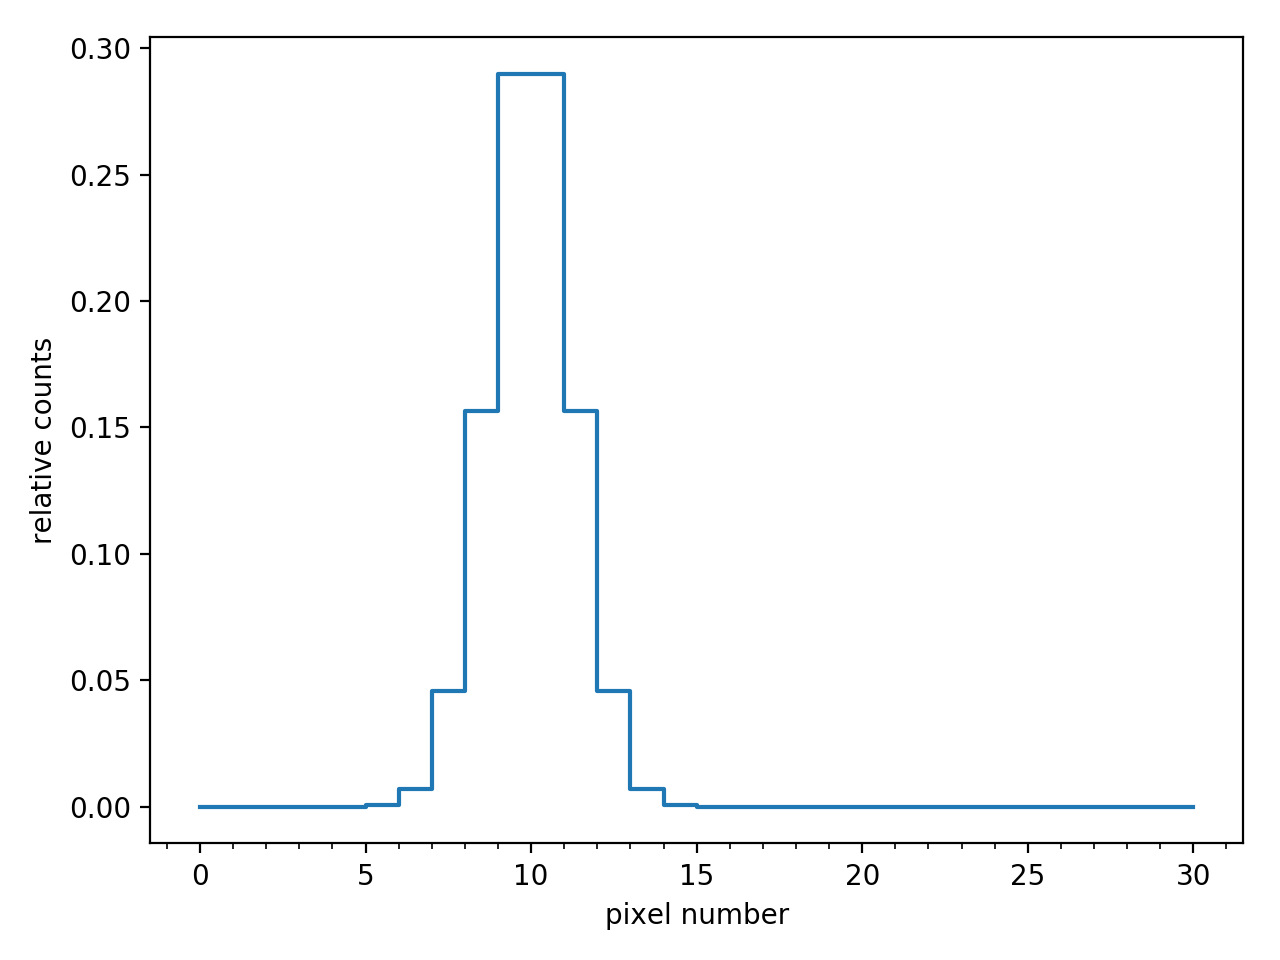

The flux of the star is: 1.000


In [5]:
x = np.linspace(0,30,31)

pixel_plot(x, phi(x+.5, 10, 3))

print("The flux of the star is: {:.3f}".format(sum(phi(x+.5, 10, 3))))

**Problem 1c**

Now add sky noise to the detector (for now we will assume the sky noise is constant in every pixel). We will define the the sky as `S`, and the total stellar flux as `F`.

Plot the simulated counts for `S` = 100 and `F` = 500. (Use the same stellar profile as **1b**)

<IPython.core.display.Javascript object>


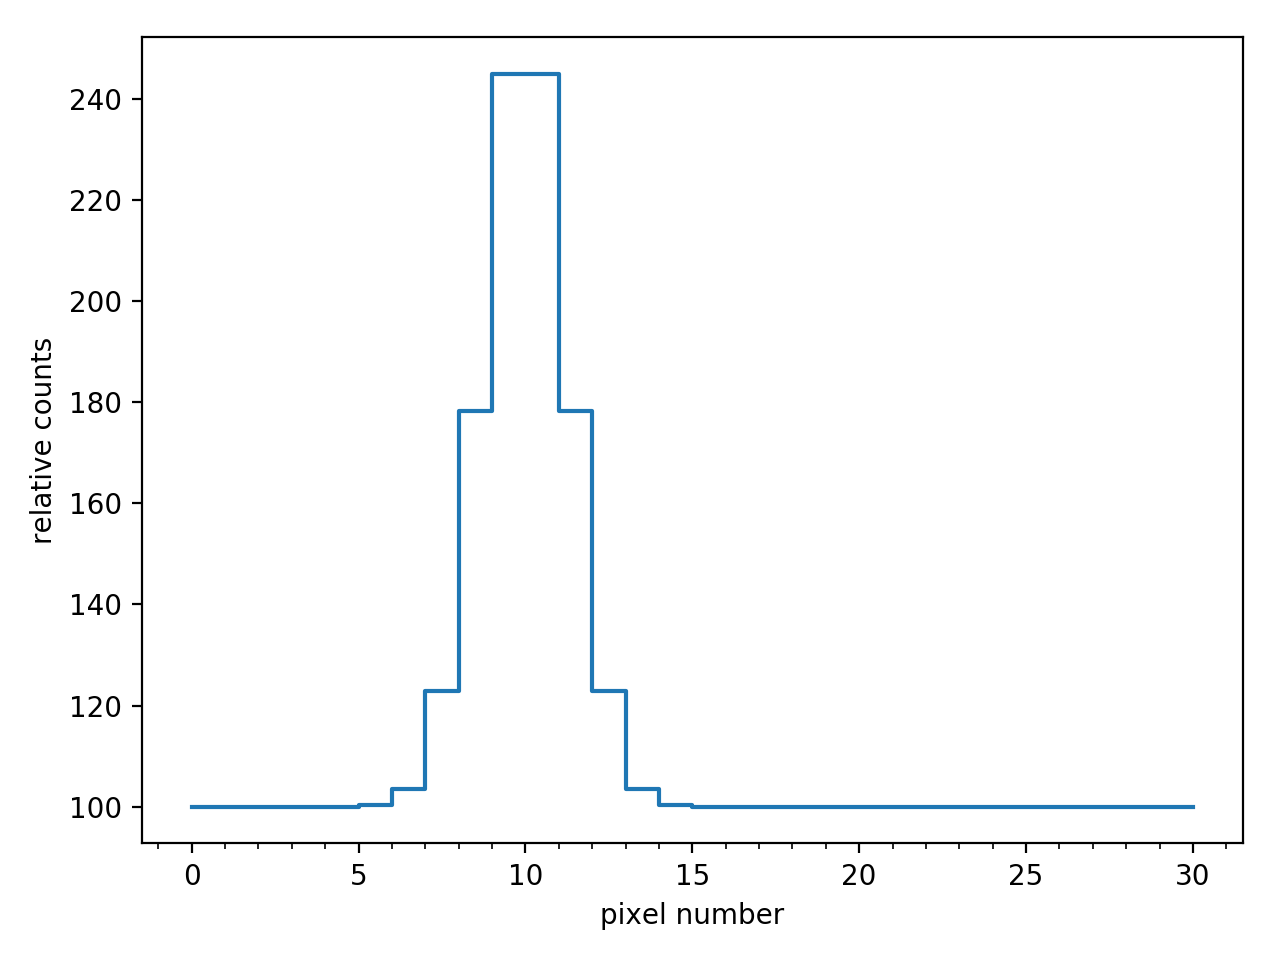

In [6]:
S = 100
F = 500

pixel_plot(x, S*np.ones_like(x) + F*phi(x+0.5, 10, 3))

## Problem 2) Add Noise

For optical detectors (such as those used by the Rubin Observatory), the noise $n$ in a pixel is almost entirely shot noise due to the finite number of photons that have been detected. Therefore, within each pixel if the "true" signal in the detector would produce $n$ photons, then the noise/uncertainty in each pixel follows a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), which has the property that the mean $\lambda$ is equal to the variance $\lambda$. If $n \gg 1$ then $P(\lambda) \approx \mathcal{N}(\lambda, \lambda)$. We will make this simplifying assumption for the remainder of this problem.

**Problem 2a**

Plot the noisy counts in each pixel for the simulated signal (star + sky) in **1c**. Visually compare these results to your previous plot.

*Hint* - you may find the function [`np.random.normal()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.normal.html) or [`np.random.poisson()`](https://numpy.org/devdocs/reference/random/generated/numpy.random.poisson.html) helpful.

<IPython.core.display.Javascript object>


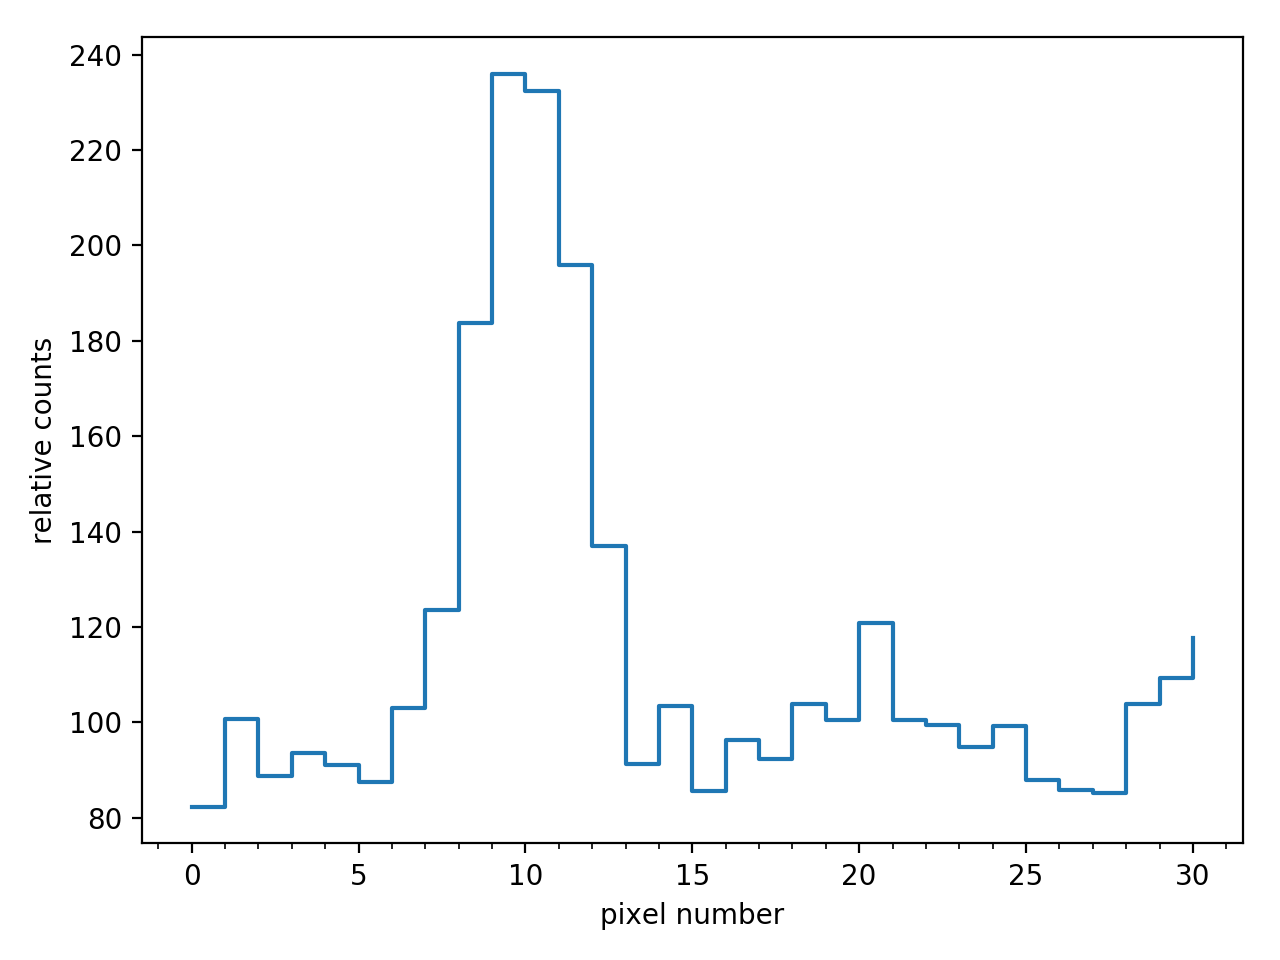

In [7]:
np.random.seed(2020)
signal = S + F*phi(x+0.5, 10, 3)
signal_plus_noise = np.random.normal(signal, np.sqrt(signal))

pixel_plot(x, signal_plus_noise)

**Problem 2b**

Estimate the flux of the star using the same method you used in **1b**.

Does your estimate match your expectation? (recall that $F = 500$) 

If not, why not?

In [8]:
print('The total flux = {:.4f}'.format(np.sum(signal_plus_noise)))

The total flux = 3533.3421


*write your answer here*

The estimated flux is much, much, much larger than the true flux of the star.

**Problem 2c**

The flux has been measured incorrectly because we are counting photons from the "sky." 

Subtract the sky background S from the counts in the detector and once again estimate the flux using the same method as **1b**.

Does your estimate match your expectation? (recall that $F = 500$) 

*Note - estimating the value of the "sky" background in real life is extremely difficult and an entire lecture will be devoted to this topic*

In [9]:
print('The total flux = {:.4f}'.format(np.sum(signal_plus_noise - S)))

The total flux = 433.3421


*write your answer here*

The flux is underestimated using this particular method.

We will now examine alternative methods of estimating the flux.

## Problem 3) Aperture Flux Measurements

In some sense, **2c** provides the most simplistic method for estimating the flux of star (add up all the counts after subtracting th background). This solution, however, cannot generalize to any sort of real life problem because there are always multiple stars (and galaxies) detected in every individual image. 

However, we can approximate the above procedure by "isolating" the individual stars in any image (say by taking a 10x10 cutout around each star), and then estimating the flux in a similar fashion. As we are about to show, the size of the box (or more appropriately a circle for 2D optical images) is critical when estimating the flux. 

**Problem 3a**

Write a function `simulate()` to simulate the noisy count measurements of a star with centroid `mu`, FWHM `fwhm`, sky background `S`, and flux `F`.

*Hint* - it may be helpful to plot the output of your function.

In [10]:
def simulate(x, mu, fwhm, S, F):
    '''simulate a noisy stellar signal
    
    Parameters
    ----------
    x : array-like
        detector pixel number
    mu : float
        mean position of the 1D star
    fwhm : float
        Full-width half-maximum of the stellar profile on the detector
    S : float
        Constant sky background in each pixel
    F : float
        Total stellar flux
    
    Returns
    -------
    noisy_counts : array-like (same shape as x)
        the (noisy) number of counts in each pixel
    '''
    source = F * phi(x+np.mean(np.diff(x))/2, mu, fwhm)
    sky_plus_source = S * np.ones_like(x) + source
    noisy_flux = np.random.normal(sky_plus_source, np.sqrt(sky_plus_source))
    
    return noisy_flux

We will now perform aperture photometry. In optical astronomy, most apertures are a top-hat function, and the flux is estimated by multiplying the aperture by the (background-subtracted) signal and summing the resulting output. In 2D apertures are typically a circle, for the remainder of this 1D problem we will use a top-hat aperture. If the aperture contains partial pixels, then the counts in pixels with parial coverage are multiplied by the fractional coverage of the pixel.

**Problem 3b** 

Using an aperture with a radius of 5 pixels centered on the source (i.e. the aperture is 10 pixels long), measure the flux from a star centered at `mu` = 20, with `fwhm` = 5, `S` = 100, and `F` = 1000. Assume you can perfectly measure the background, and subtract this prior to measuring the flux.

**Extra long** *Hint* - if you create your aperture using a single `np.where()` command (or similar) you are not going to get the correct answer. To quickly see why this is the case, imagine you'd been asked to use an aperture with a radius of 3.2 pixels. Thus, properly calculating the aperture requires a bit of thought. A for loop is a fairly intuitive way to handle this problem (though it can also be done with a series of where commands, and both possibilities will be presented in the solutions). 

**DO NOT SPEND TOO MUCH TIME ON THIS PROBLEM** If you get stuck, use a single `np.where()` command. When you plot the results in the **3c** you'll see how things are off, but this won't affect the general results in the remainder of the notebook. 

In [11]:
x = np.linspace(0,40,41)
mu = 20
S = 100
fwhm = 5
F = 1000
sim_star = simulate(x, mu, fwhm, S, F)

ap_radius = 5
aperture_mask = np.zeros_like(x)
# somewhat vectorized solution
aperture_mask[np.where((np.abs(x + 1 - mu) <= ap_radius) & 
                  (np.abs(x - mu) <= ap_radius))] = 1
low_pix = np.where((np.abs(x + 1 - mu) <= ap_radius) & 
                   (np.abs(x - mu) > ap_radius))
aperture_mask[low_pix] = ap_radius - (mu - (x[low_pix] + 1))
high_pix = np.where((np.abs(x + 1 - mu) > ap_radius) & 
                   (np.abs(x - mu) <= ap_radius))
aperture_mask[high_pix] = ap_radius - (x[high_pix] - mu)

# for loop solution
# for pix_num, pix in enumerate(x):
#     if 0 <= np.abs(mu - (pix + 1)) <= ap_radius:
#         aperture_mask[pix_num] = min(1, np.abs(ap_radius - np.abs(pix + 1 - mu)))
#     if 0 <= pix - mu <= ap_radius:
#         aperture_mask[pix_num] = min(1, ap_radius - np.abs(pix - mu))
        
ap_flux = np.sum((sim_star - S)*aperture_mask)

print("The star has flux = {:.3f}".format(ap_flux))

The star has flux = 1062.804


**Problem 3c**

Plot the simulated counts from **3b** and overplot your aperture. You may want to multiple the aperture by a factor of 100 to see it better.

*Hint* – after you have run `pixel_plot()` you will need to call matplotlib functions directly (e.g., `plt.plot`) to overplot on the pixel data. Also, if you created an `aperture_mask` in **3b** it may help to plot that as well.

<IPython.core.display.Javascript object>


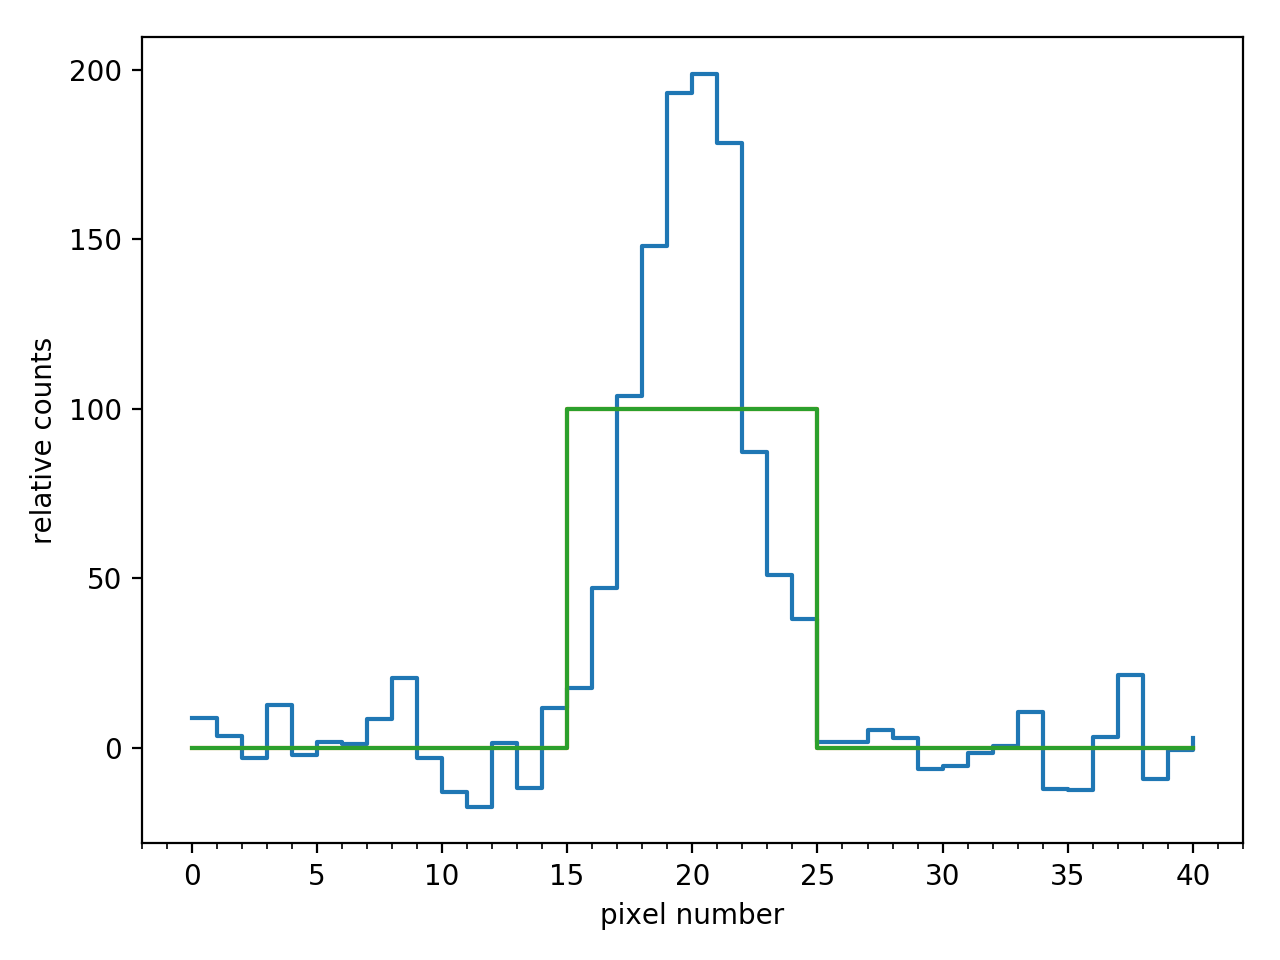

In [12]:
pixel_plot(x, sim_star-S)
# add aperture
plt.plot([0,mu-ap_radius, mu-ap_radius, mu+ap_radius,mu+ap_radius, np.max(x)], [0,0,100,100,0,0])
# add aperture_mask -- only different with non-integer aperture radius
plt.step(x, aperture_mask*100, where='post')

**Problem 3c** 

Write a Monte Carlo simulator to estimate the mean and standard deviation of the flux from the simulated star.

*Food for thought* - what do you notice if you run your simulator many times?

In [13]:
sim_fluxes = np.empty(1000)
for sim_num, dummy in enumerate(sim_fluxes):
    sim_star = simulate(x, mu, 5, S, 1000)
    
    ap_radius = 5
    aperture_mask = np.zeros_like(x)
    # somewhat vectorized solution
    aperture_mask[np.where((np.abs(x + 1 - mu) <= ap_radius) & 
                      (np.abs(x - mu) <= ap_radius))] = 1
    low_pix = np.where((np.abs(x + 1 - mu) <= ap_radius) & 
                       (np.abs(x - mu) > ap_radius))
    aperture_mask[low_pix] = ap_radius - (mu - (x[low_pix] + 1))
    high_pix = np.where((np.abs(x + 1 - mu) > ap_radius) & 
                       (np.abs(x - mu) <= ap_radius))
    aperture_mask[high_pix] = ap_radius - (x[high_pix] - mu)

    ap_flux = np.sum((sim_star - S)*aperture_mask)    
    
    sim_fluxes[sim_num] = ap_flux

print("The mean flux = {:.3f} with variance = {:.3f}".format(np.mean(sim_fluxes),
                                                             np.var(sim_fluxes, ddof=1)))

The mean flux = 984.078 with variance = 1891.594


## Problem 4) Avoid Arbitrary Numbers -- the Curve of Growth

In **Problem 3** we decided to use an aperture radius of 5. Why? 

(In practice, an aperture radius equal to the FWHM is a pretty good choice, as we will show below. However, this is not optimal in all situations)

We will now try to optimize the choice of aperture for the star in question.

**Problem 4a**

Using your solution to **Problem 3**, write a function `aperture_flux()` that estimates the mean flux and it's variance in a given aperture of size `ap_radius` for a simulated star. 

*Hint* - this function is going to have many inputs, `ap_radius`, the position of the star, the flux of the star, the FWHM of the star, a pixel grid, the value of the sky background, and the number of simulations per input radius.

In [14]:
def aperture_flux(ap_radius, 
                  x=np.linspace(0,40,41),
                  mu=20,
                  fwhm=5,
                  S=100,
                  F=1000,
                  n_sim=1000):
    '''Measure mean and variance of flux in a given aperture
    
    Parameters
    ----------
    ap_radius : float
        radius of the top hat aperture
    x : array-like (default: np.arange(0,40,41))
        grid of simulated pixels
    mu : float (default: 20)
        position of the star
    fhwm : float (default: 5)
        FWHM of the stellar profile
    S : float (default: 100)
        level of the sky background
    F : float (default: 1000)
        stellar flux
    n_sim : float (default: 1000)
        number of simulations
    
    Returns
    -------
    mean_flux, variance
    '''
    
    sim_fluxes = np.empty(n_sim)
    for sim_num, dummy in enumerate(sim_fluxes):
        sim_star = simulate(x, mu, fwhm, S, F)

        aperture_mask = np.zeros_like(x)
        # somewhat vectorized solution
        aperture_mask[np.where((np.abs(x + 1 - mu) <= ap_radius) & 
                          (np.abs(x - mu) <= ap_radius))] = 1
        low_pix = np.where((np.abs(x + 1 - mu) <= ap_radius) & 
                           (np.abs(x - mu) > ap_radius))
        aperture_mask[low_pix] = ap_radius - (mu - (x[low_pix] + 1))
        high_pix = np.where((np.abs(x + 1 - mu) > ap_radius) & 
                           (np.abs(x - mu) <= ap_radius))
        aperture_mask[high_pix] = ap_radius - (x[high_pix] - mu)

        ap_flux = np.sum((sim_star - S)*aperture_mask)    

        sim_fluxes[sim_num] = ap_flux
    return np.mean(sim_fluxes), np.var(sim_fluxes, ddof=1)

**Problem 4b**

Confirm your function works by calculating the mean and variance of the flux in a 5 pixel radius aperture. 

In [15]:
mean, var = aperture_flux(5)

print('The mean flux in a r = 5 pix aperture is {:.4f} +/- {:.4f}'.format(mean, np.sqrt(var)))

The mean flux in a r = 5 pix aperture is 982.8639 +/- 45.6390


**Problem 4c**

Build successively larger apertures with sizes increasing from a radius of 1 to 10 pixels. Measure the mean and variance for each aperture size. Plot the results.

Which aperture size has the smallest variance? Is this aperture best? 

Do these results make sense?

<IPython.core.display.Javascript object>


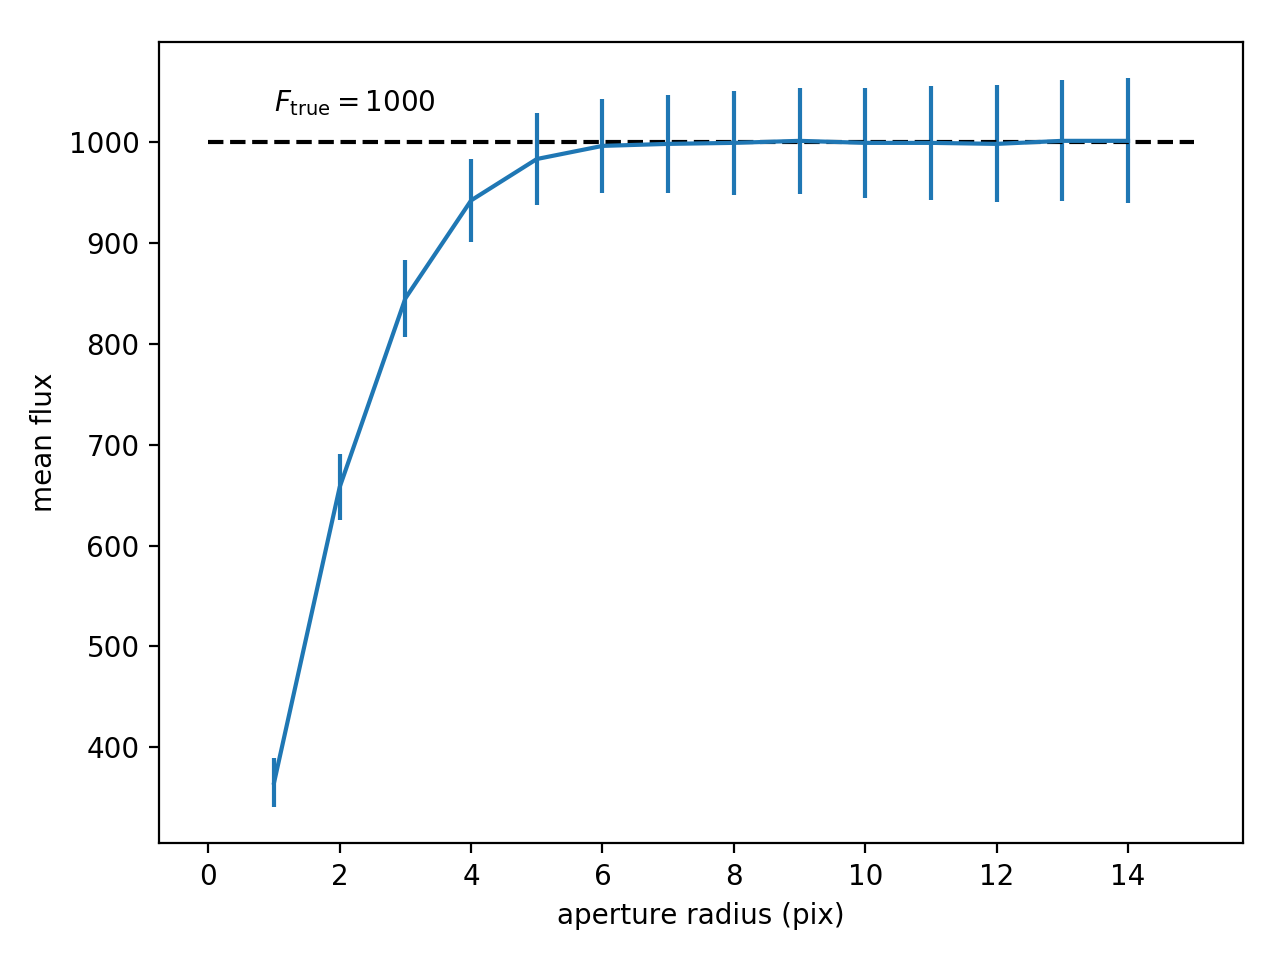

aperture radius = 1 has the smallest variance


In [16]:
ap_array = np.arange(1,15)
ap_mean = np.zeros_like(ap_array)
ap_var = np.zeros_like(ap_array)

for ap_num, ap_rad in enumerate(ap_array):
    ap_mean[ap_num], ap_var[ap_num] = aperture_flux(ap_rad, n_sim=5000)

fig, ax = plt.subplots()
ax.errorbar(ap_array, ap_mean, np.sqrt(ap_var))
ax.hlines(1000, 0,15, linestyles='dashed')
ax.text(1,1030,r'$F_\mathrm{true} = 1000$')
ax.set_xlabel('aperture radius (pix)')
ax.set_ylabel('mean flux')
fig.tight_layout()

print('aperture radius = {} has the smallest variance'.format(ap_array[np.argmin(ap_var)]))

*write your answer here*

An aperture with a radius = 1 pixel has the smallest variance, however, this significantly underestimates the true flux. On the other hand, all the apertures with $r \gtrsim 7$ pixels do a seemingly equally good job of estimating the flux, but they have high variance estimates.

The fact that the small apertures do a poor job of estimating the flux makes sense because they are excluding clear signal from the source.

Small apertures fail to measure all the light from the source. Large apertures do measure all the light, but at the cost of higher variance. 

In practice, these challenges can be alleviated if the point spread function is known. (This is a challenging problem and the subject of an entire lecture this week, as the PSF is essentially never known a priori and must be estimated from the images themselves.)

In this case, we know the PSF is a 1D Gaussian. We can therefore calculate "aperture corrections" to determine the flux at any radius on the above plot (known as the curve of growth -- in some cases the aperture corrections can be determined directly from the curve of growth but that can be challenging on real images, as things like stellar blends remove all the simplicity of the single star problem that we have here).

To determine the aperture correction at any radius $r$, we can simply integrate a Gaussian (our know PSF for this simulated problem) over the size of the aperture and then divide the aperture flux (and standard deviation) by this result to estimate the true flux in each aperture.

This can easily be done for our 1D Gaussian with scipy.

In [17]:
from scipy.stats import norm

def curve_of_growth(r):
    '''Return aperture correction for aperture of size r
    
    Parameters
    ----------
    r : float
        radius of the aperture, in units of the 
        Gaussian standard deviation
    
    Returns
    -------
    apcor : float
        the aperture correction at radius r
    
    '''

    return norm.cdf(r) - norm.cdf(-r)

**Problem 4d**

Calculate the analytic curve of growth for each of your apertures from **4c**. Re-plot the (corrected) flux in each aperture. Do you notice anything different? 

*Hint* – recall the relation between FWHM and the standard deviation for a Gaussian.

<IPython.core.display.Javascript object>


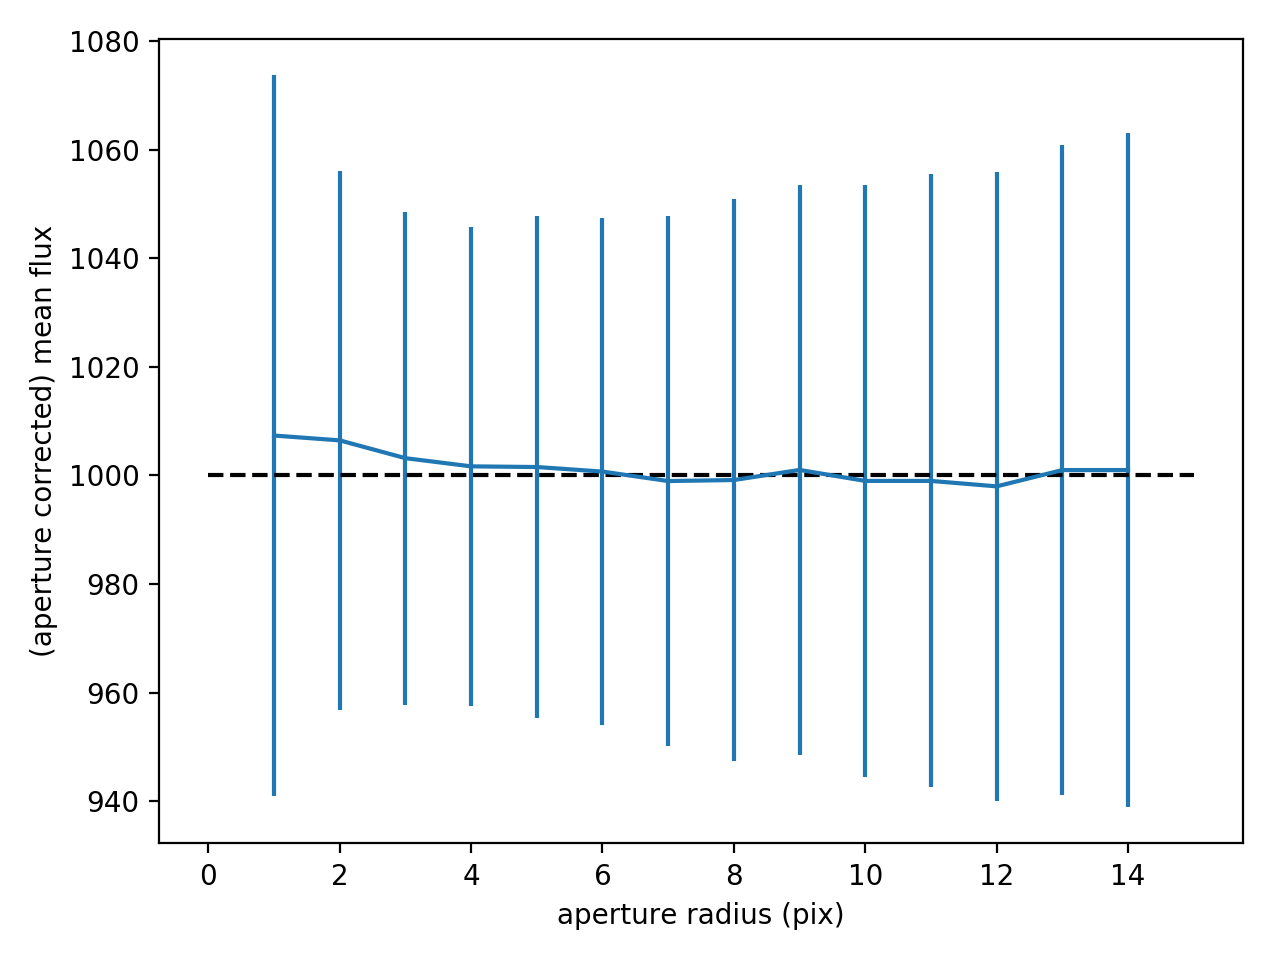

In [18]:
cog = curve_of_growth(ap_array/(2.5/np.sqrt(2*np.log(2))))

fig, ax = plt.subplots()
ax.errorbar(ap_array, ap_mean/cog, np.sqrt(ap_var)/cog)
ax.hlines(1000, 0,15, linestyles='dashed')
# ax.text(1,1030,r'$F_\mathrm{true} = 1000$')
ax.set_xlabel('aperture radius (pix)')
ax.set_ylabel('(aperture corrected) mean flux')
fig.tight_layout()

**Problem 4e**

Plot the uncertainty on the flux estimate (i.e., the square root of the variance) as a function of aperture radius.

Now which aperture size do you think is best?

<IPython.core.display.Javascript object>


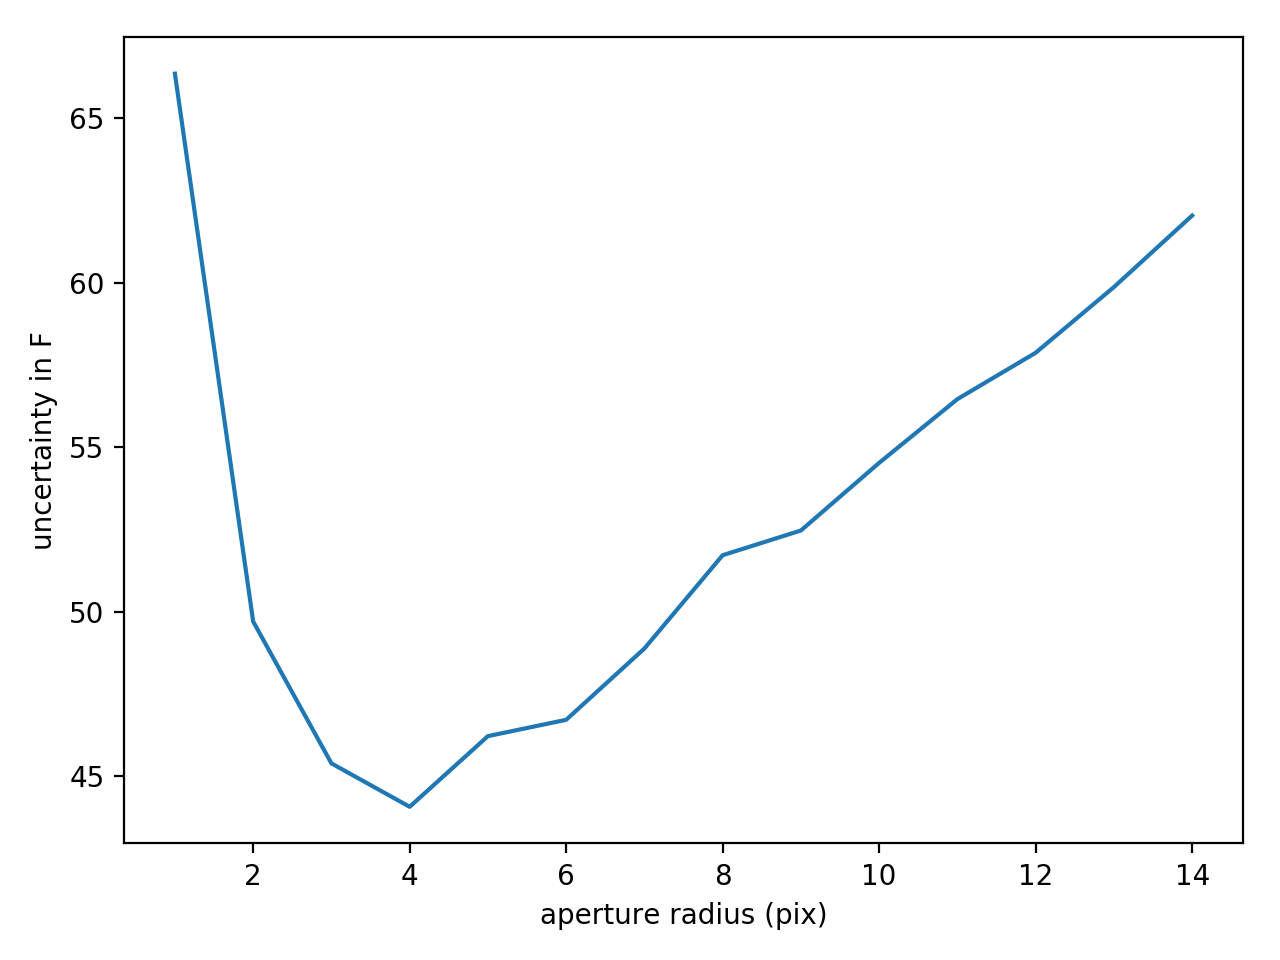

In [19]:
fig, ax = plt.subplots()
ax.plot(ap_array, np.sqrt(ap_var)/cog)
ax.set_xlabel('aperture radius (pix)')
ax.set_ylabel('uncertainty in F')
fig.tight_layout()

*write your answer here*

The optimal radius appears to be ~4 pixels. (Note - this is really close to the FWHM as we discussed previously)

Here we have discovered a universal truth about aperture photometry: very small and very large apertures produce lower signal-to-noise estimates than something in between. 

However, the optimal value of that something in between is different for every star (as you will show below). 

**Problem 4f**

Leaving all other variables the same, estimate the optimal aperture size (i.e. maximize the signal-to-noise ratio) for a star with a flux of 10000.

What is the optimal aperture size?

*Hint* –– you only need to repeat **4c** and **4e** for this answer.

<IPython.core.display.Javascript object>


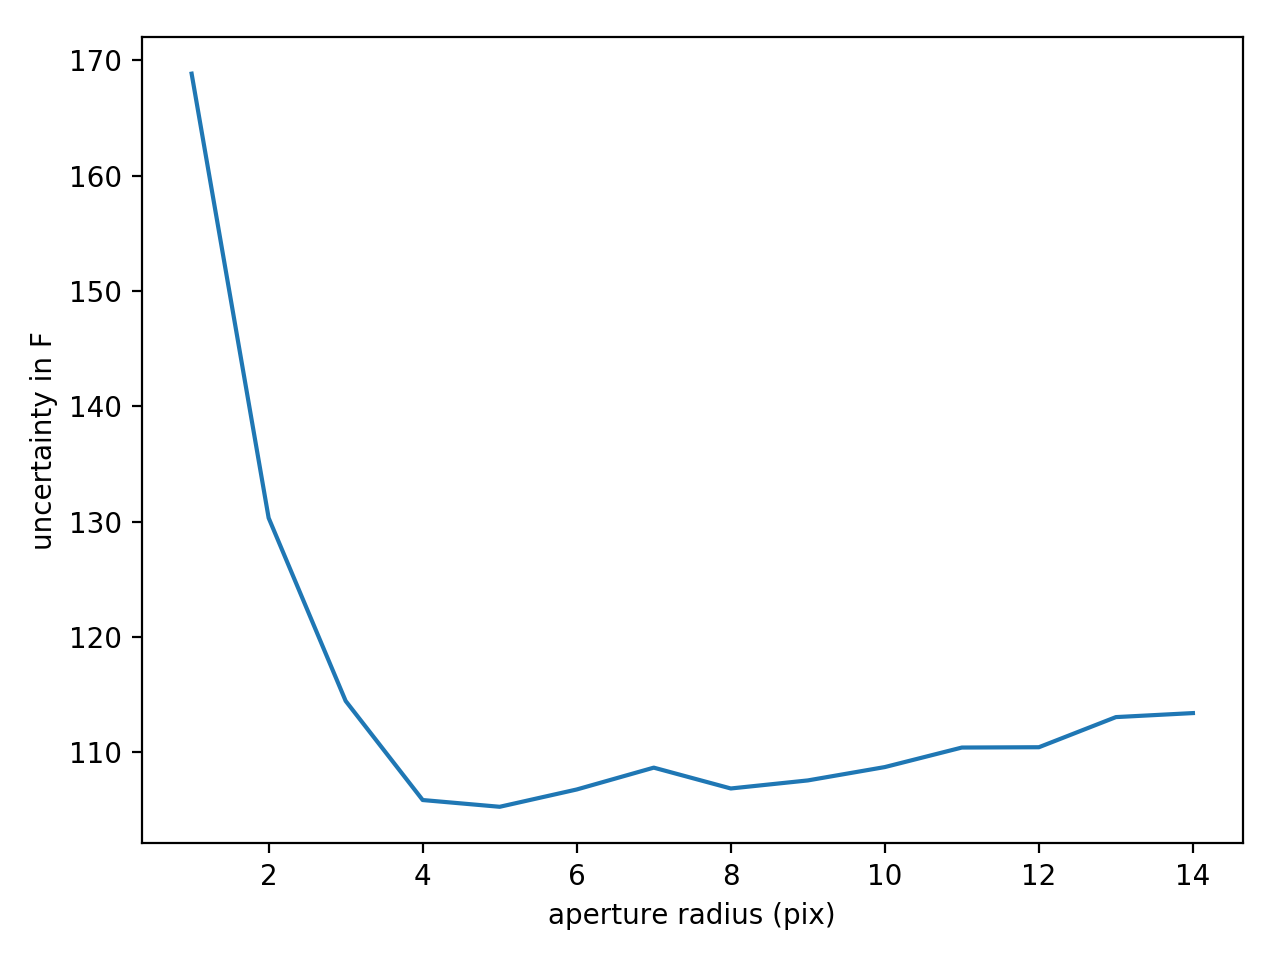

The optimal aperture is 5 pix


In [20]:
ap_mean = np.zeros_like(ap_array)
ap_var = np.zeros_like(ap_array)

for ap_num, ap_rad in enumerate(ap_array):
    ap_mean[ap_num], ap_var[ap_num] = aperture_flux(ap_rad, F=1e4, n_sim=3000)

    
fig, ax = plt.subplots()
ax.plot(ap_array, np.sqrt(ap_var)/cog)
ax.set_xlabel('aperture radius (pix)')
ax.set_ylabel('uncertainty in F')
fig.tight_layout()

print('The optimal aperture is {} pix'.format(ap_array[np.argmin(np.sqrt(ap_var)/cog)]))

**Problem 4g**

Leaving all other variables the same, estimate the optimal aperture size (i.e. maximize the signal-to-noise ratio) for a star with a flux of 10.

What is the optimal aperture size? 

Can you even measure the flux of this star?

<IPython.core.display.Javascript object>


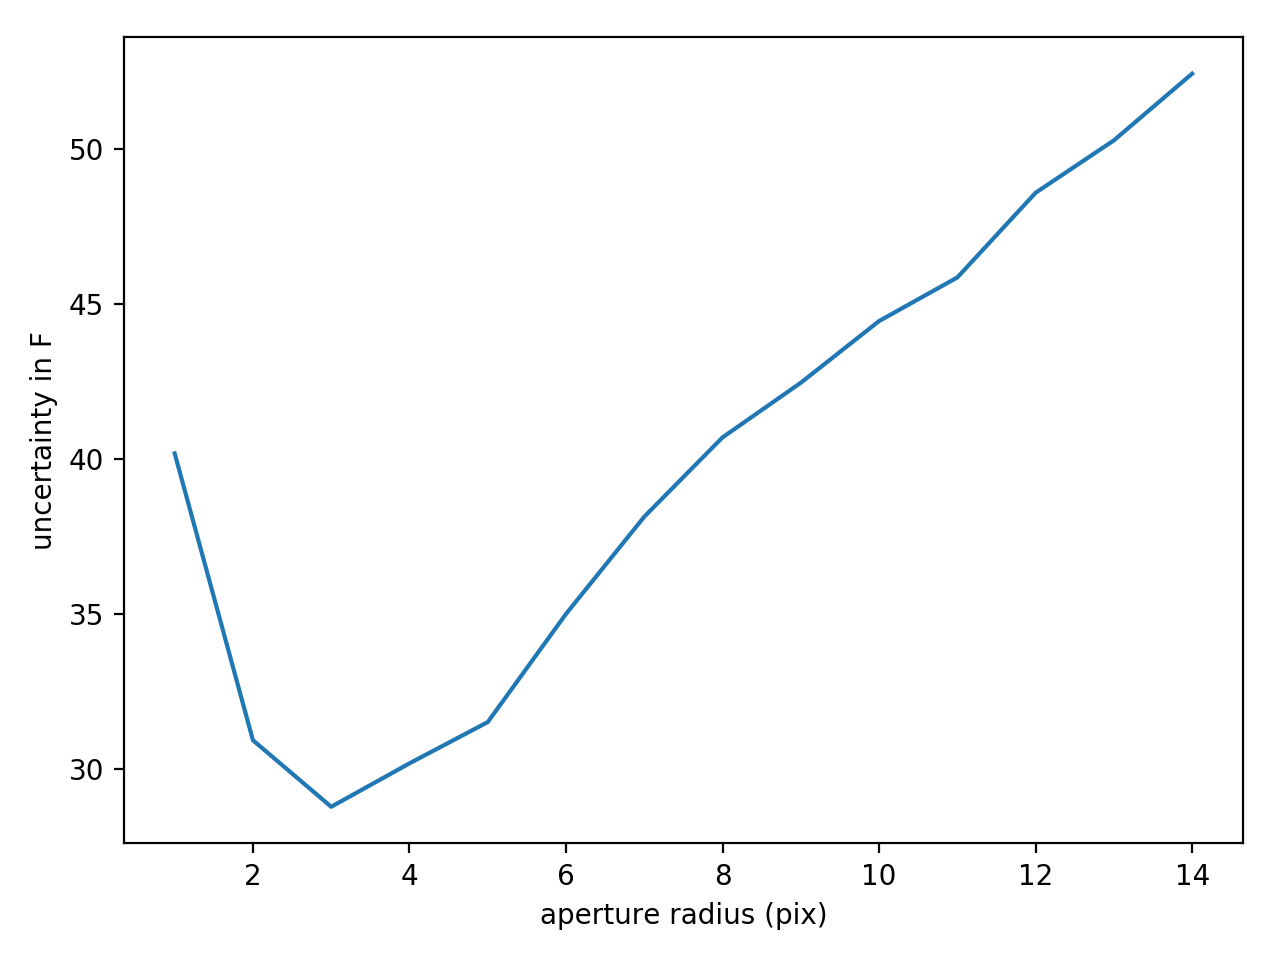

The optimal aperture is 3 pix


In [21]:
ap_mean = np.zeros_like(ap_array)
ap_var = np.zeros_like(ap_array)

for ap_num, ap_rad in enumerate(ap_array):
    ap_mean[ap_num], ap_var[ap_num] = aperture_flux(ap_rad, F=10, n_sim=3000)

    
fig, ax = plt.subplots()
ax.plot(ap_array, np.sqrt(ap_var)/cog)
ax.set_xlabel('aperture radius (pix)')
ax.set_ylabel('uncertainty in F')
fig.tight_layout()

print('The optimal aperture is {} pix'.format(ap_array[np.argmin(np.sqrt(ap_var)/cog)]))

#### Upshot

Dropping simple apertures on an image provides a fast and simple method to estimate the flux of a star. 

This approach comes at a cost, however, as the aperture method employed here provides high variance estimates of the flux. 

Fortunately, it is possible to do much better via PSF photometry (and in fact, the [Cramer-Rao bound](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound) mathematically proves that PSF photometry is the lowest variance estimator of the flux of a star). This means that *aperture photometry is never better than PSF photometry* despite some claims to contrary in the literature. There are cases where the PSF is extremely difficult to estimate, in which case aperture photometry may be the only decent way to estimate the flux, but even then PSF photometry would be better.

(Technically speaking, aperture photometry *is* PSF photometry. The catch is that the PSF model (a 1D or circular top hat) is a terrible match to the actual aparition of the stars on the image. When the model of the PSF is good, and in the case of our simulated data set we know the PSF perfectly, then PSF flux estimates will be a minimum variance estimator.)


## Problem 5/Challenge Problem) PSF Flux measurement

We are going to cover PSF modeling and PSF photometry in far greater detail later this week, but here we are going to quickly meausure the flux using a model of the PSF, which we will compare to the aperture results.

**Problem 5a**

Create the psf model, `psf`, which is equivalent to a noise-free star with `fwhm` = 5.

In [22]:
psf = phi(x+.5, mu, fwhm)

**Problem 5b** 

Using the same parameters as problem 3, simulate a star and measure it's PSF flux.

*Hint* - you may find the [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function from `scipy.optimize` helpful.

In [23]:
from scipy.optimize import minimize

# minimize the square of the residuals to determine flux
def sum_res(A, flux=sim_star-S, model=psf):
    return sum((flux - A*model)**2)



sim_star = simulate(x, mu, fwhm, S, F)
psf_flux = minimize(sum_res, 980, args=(sim_star-S, psf))

print("The PSF flux is {:.3f}".format(psf_flux.x[0]))

The PSF flux is 982.672


**Problem 5c**

Following **4a** write a function to simulate many realizations of the star and estimate  the flux and variance using the PSF model.

How does the PSF estimate compare to the aperture estimate?

In [24]:
sim_fluxes = np.empty(5000)
for sim_num, dummy in enumerate(sim_fluxes):
    sim_star = simulate(x, mu, fwhm, S, F)
    psf_flux = minimize(sum_res, 980, args=(sim_star-S, psf))
    
    
    sim_fluxes[sim_num] = psf_flux.x[0]

print("The mean flux = {:.3f} with variance = {:.3f}".format(np.mean(sim_fluxes),
                                                             np.var(sim_fluxes, ddof=1)))

The mean flux = 999.875 with variance = 1860.235


*write your answer here*

The optimal aperture had a radius of 4 and an rms ~ 44.5 in **4e**. The rms for the PSF photometry is ~43.8, meaning it provides a lower variance estimate of the flux. 